# Brain Decoding based on Functional Connectivity


## Motivation
Haxby is a 4-D fMRI dataset, where we can get a time-series data (1452 samples each) of each voxel (a volumn of 40 $\times$  64 $\times$ 64). 
We want to predict what participants perceived based on the brain activity/responses, represented by sampled fMRI image. -> Classification Task

**Sample**: time-series samples

**Features**: What can act as features?

We first narrow down to Regions of Interests (ROI)
* The actual ROI value at each sampling time (what most ML/DL algorithms use)
* **ROI's temporal pattern: How does the voxel value change when the participant was given different stimulus?**


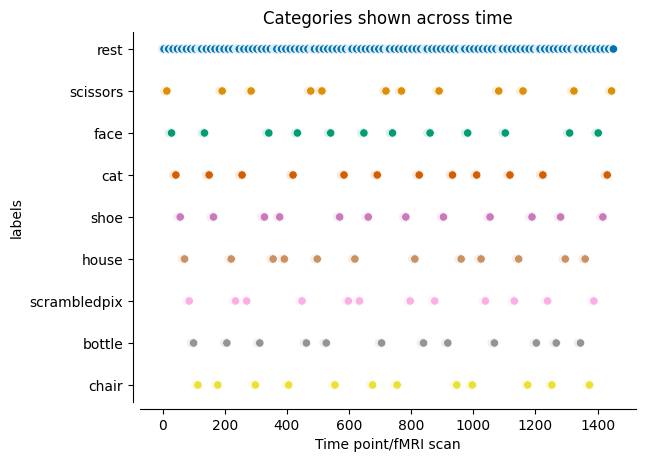

In [21]:
import pandas as pd
stimulus_annotations = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.scatterplot(x=stimulus_annotations.index, y=stimulus_annotations['labels'], 
                     hue=stimulus_annotations['labels'], legend=False, palette='colorblind')
plt.title('Categories shown across time')
ax.set_xlabel('Time point/fMRI scan')
sns.despine(offset=5)

# Problem Formulation

Given temporal data of voxel value within the ROI, we:

* Find **representitive metrics** to describe temporal pattern of different stimuli
* Build **supervised classification models** (especially **geometry ML methods**), train with stimulus-labeled representitive metrics
* Predict what kind of stimulus that the participant perceived based on our models

# Implementation Details

* We choose multiple stimulus-labeled **funtional connectivity** metrics to represent ROI's temporal pattern
  * Pearson correlation matrix
  * inverse covariance matrix, i.e. precision matrix
  * partial correlation
* Organize the dataset
  * Extract the masked ROI data of different stimulus interval
  * data - label pairs
* Geometric machine learning methods for classification (decoding)
  * Tangent Machine Learning
    * Corelation matrices belong to the manifold of SPD matrices
    * Consider the tangent space $T_{\overline{x}}M$ of the manifold M at the Frechet mean $\overline{x}$ of the data points, to transform our dataset into a vector space
    * Then apply traditional ML algorithms
      * Linear Support Vector Classifier (Linear-SVC)
  * Keep the data on the manifold
    * Reimann Minimum Distance to Mean
* Compare the results with ML/DL methods using one-time sample data

# Package Installation

In [ ]:
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-geometric

In [ ]:
!pip install umap
!pip install pipreqs
!pip install lazypredict
!pip install nibabel
!pip install nilearn
!pip install -U kaleido


try:
    import sklearn
    print('Scikit-learn is available, version', sklearn.__version__)
    
except:
    !pip install scikit-learn
    
try:
    import numpy as np
    print('Numpy is available, version', np.__version__)
    
except:
    !pip install numpy
    
try:
    import pandas as pd
    print('Pandas is available, version', pd.__version__)
    
except:
    !pip install pandas

try:
    import scipy
    print(' Scipy is available, version', scipy.__version__)
    
except:
    !pip install scipy
    
try:
    import plotly
    
except:
    !pip install plotly    

# Get Haxby dataset

## Imports

In [1]:
# Basics:
import numpy as np,pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import os, random, time, sys, copy, math, pickle

# For plotting
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

# Utilies:
from tqdm import tqdm

# For distance measurements:
from scipy.spatial.distance import cdist

# Extras:
from abc import abstractmethod
from typing import Callable, Iterable, List, Tuple

# For neuroimaging:
from nibabel.testing import data_path
from nilearn import plotting as nplt
from nilearn.input_data import NiftiMasker
from nilearn import datasets
from nilearn import plotting
from nilearn.image import mean_img
from nilearn.image import index_img
import nibabel as nib
from nilearn import image

from func import *

from utils.timers import timeit
from utils.metrics import accuracy, confusion_matrix, visualize_confusion_matrix
from utils.savers import save, save_obj, load, load_obj
from utils.reproduce import random_seed
from dataset.dataloader import fetch_masked_haxby_per_stimuli, fetch_masked_haxby_with_stimuli_label
from dataset.fetch_data_matrix import fetch_from_haxby
from visualizer.plot2D import plot_2d
from visualizer.plot3D import plot_3d 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'data')
image_results_dir = os.path.join(root_dir, 'images')
results_dir = os.path.join(root_dir, 'results')
explanatory_fMRI_dir = os.path.join(image_results_dir, 'explanatory')

print('Working Directory: \n ', root_dir)

# fetch dataset
haxby_dataset = datasets.fetch_haxby(subjects=[1,2,3,4,5,6], fetch_stimuli=True, data_dir=data_dir)

stimuli2category = {
    'scissors'     : 0,
    'face'         : 1, 
    'cat'          : 2,
    'scrambledpix' : 3,
    'bottle'       : 4,
    'chair'        : 5,
    'shoe'         : 6,
    'house'        : 7,
    'rest'         : 8
}

D:\Software\Anaconda\envs\geometry\Lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Working Directory: 
  d:\UCSB\ECE594N\final_proj\ece_594_final\ece594n


## Functional Connectivity and Similarity Analysis

Functional connectivity is defined as the temporal dependency of neuronal activation patterns of anatomically separated brain regions. Functional connectivity is often measured by the level of co-activation of resting-state fMRI time-series between brain regions, which can be obtained by estimating a covariance (or
correlation) matrix for signals from different brain regions.

We performed functional connectivity analysis based on the correlation, precision, and partial correlation, and similarity analysis based on the cosine, minkowski, and euclidean distance to discover overlapping representation in the ventral temporal cortex.

This is quite useful in explanatory fMRI analysis as it shows how distributed regions in human brain shares similar features from statistical and mathematical perspective. 


## Coorelation

### Coorelation matrix of the whole time

In [ ]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
subject_id = 0
correlation_matrix = correlation_measure.fit_transform([masks[subject_id]])[0]

fig = plt.figure()

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix,
                     colorbar=True,
                     vmax=0.8, vmin=-0.8,
                     figure = fig)
plotting.show()

fig.savefig(os.path.join(explanatory_fMRI_dir, 'correlation.png'))

### Correlation Matrix during each stimulus

In [ ]:
num_subjects = 1
subject_id = 0

func_file = haxby_dataset.func[subject_id]

labeled_numpy_fmri, labeled_masked = fetch_masked_haxby_per_stimuli(haxby_dataset, subject_id)

<Figure size 640x480 with 0 Axes>

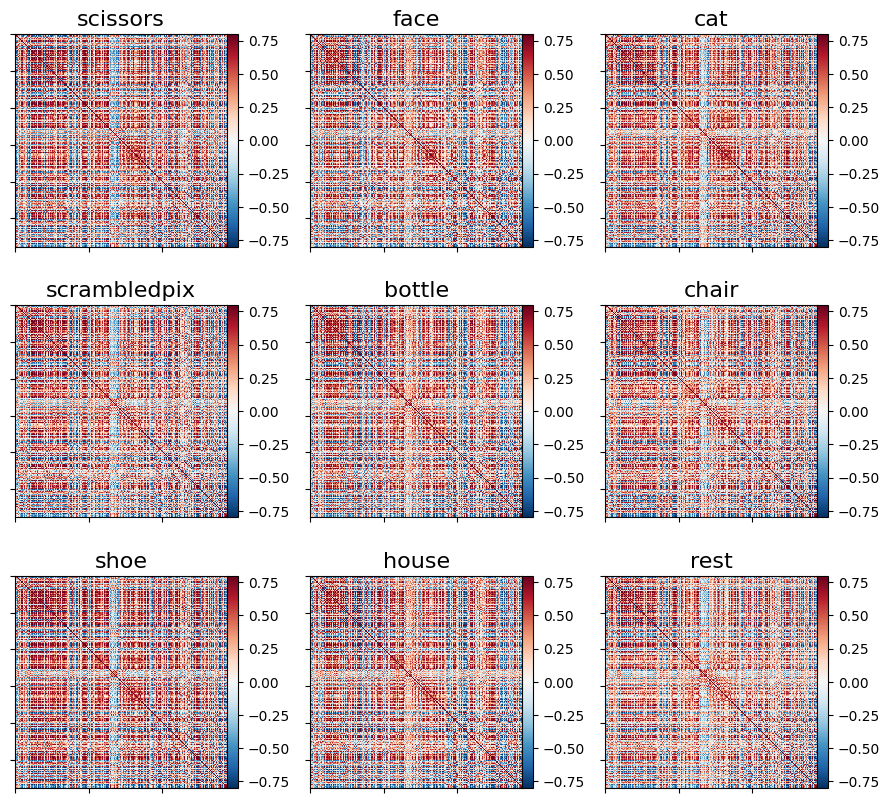

In [81]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
# correlation_measure = ConnectivityMeasure(kind='precision')
# correlation_measure = ConnectivityMeasure(kind='partial correlation')
subject_id = 0


fig = plt.figure()
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
# Flatten the array of subplots to iterate over them
axs = axs.flatten()

labeled_cor_mat = dict()

#for idx, (stimuli, stimuli_id) in enumerate(stimuli2category.items()):
for stimuli, stimuli_id in stimuli2category.items():
    # Create correlation_matrix of this stimuli
    correlation_matrix = correlation_measure.fit_transform([labeled_masked[stimuli]])[0]
    # Mask out the major diagonal
    np.fill_diagonal(correlation_matrix, 1)

    labeled_cor_mat[stimuli] = correlation_matrix
    
    # plot
    axs[stimuli_id].set_title(stimuli, fontsize=16)
    plotting.plot_matrix(correlation_matrix,
                        colorbar=True,
                        vmax=0.8, vmin=-0.8,
                        axes=axs[stimuli_id]
                        )
# plotting.show()
plt.show()

fig.savefig(os.path.join(explanatory_fMRI_dir, 'labeled correlation.png'))

In [ ]:
# # Data Preprocess

# num_subjects = 1
# subject_id = 0

# stimuli_mask_list = fetch_masked_haxby_with_stimuli_label(haxby_dataset, subject_id)
# # Saving the data for future use:
# save(stimuli_mask_list, 'stimuli_mask_list')

### Load pre-processed data

In [88]:
# Load data. saved as a numpy array, need to convert to list

stimuli_mask_list_0 = load('data/stimuli_mask_list_0').tolist()
# stimuli_mask_list_1 = load('stimuli_mask_list_1').tolist()
# stimuli_mask_list_2 = load('stimuli_mask_list_2').tolist()

# subject_list = [0,1,2]
# stimuli_mask_list = []
# for subject in subject_list:
#     stimuli_mask_list.extend(load('stimuli_mask_list_'+str(subject)).tolist())

stimuli_mask_list = stimuli_mask_list_0

print(len(stimuli_mask_list))

192


### Correlation of each shown

<Figure size 640x480 with 0 Axes>

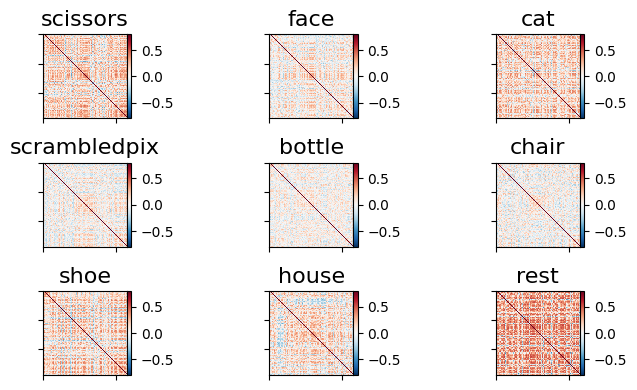

In [96]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
# correlation_measure = ConnectivityMeasure(kind='precision')
# correlation_measure = ConnectivityMeasure(kind='partial correlation')

subject_id = 0

# key: coorelation matrix value: stimuli label
# so that X -> key, y -> value
# cormat_label = dict()
cormat_label_list = []

#for idx, (stimuli, stimuli_id) in enumerate(stimuli2category.items()):
for stimuli_mask in stimuli_mask_list:
    stimuli = stimuli_mask['stimuli']
    mask = stimuli_mask['mask']
    # Create correlation_matrix of this stimuli
    correlation_matrix = correlation_measure.fit_transform([mask])[0]
    # Mask out the major diagonal
    np.fill_diagonal(correlation_matrix, 1.)

    # create X-y pairs
    # cormat_label[correlation_matrix] = stimuli2category[stimuli]

    cormat_label_list.append({'label': stimuli2category[stimuli], 'data': correlation_matrix})
    
# plot samples for different label
fig = plt.figure()
fig, axs = plt.subplots(3, 3, figsize=(8, 4))
# Flatten the array of subplots to iterate over them
axs = axs.flatten()

def get_key_by_value(dct, value):
    for k, v in dct.items():
        if v == value:
            return k

label_num = 0
for idx, sample in enumerate(cormat_label_list[20:100]):
    label = sample['label']
    if label == label_num:
        correlation_matrix  = sample['data']
        axs[label_num].set_title(get_key_by_value(stimuli2category, label), fontsize=16)
        plotting.plot_matrix(correlation_matrix,
                            colorbar=True,
                            vmax=0.8, vmin=-0.8,
                            axes=axs[label_num]
                            )
        label_num = label_num + 1
# plotting.show()
plt.show()

fig.savefig(os.path.join(explanatory_fMRI_dir, 'sampled shown correlation.png'))

## Tangent Machine Learning

### Split dataset into train/test sets

In [90]:
from geomstats.learning.preprocessing import ToTangentSpace
from sklearn.pipeline import Pipeline

import geomstats.backend as gs
from sklearn.model_selection import train_test_split

# Define the manifold where the co-re matrix layes
from geomstats.geometry.spd_matrices import SPDMatrices
spd_manifold = SPDMatrices(n=577)

X = gs.array([cormat_label['data'] for cormat_label in cormat_label_list])

# 9 categories
# y = gs.array([cormat_label['label'] for cormat_label in cormat_label_list])

# 2 categories
category_list = [0]
y = gs.array([1
              if cormat_label['label'] in category_list
              else 0
              for cormat_label in cormat_label_list
            ])

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"The dataset has {len(X)} connectomes.")
print(f"The train set has {len(X_train)} connectomes.")
print(f"The test set has {len(X_test)} connectomes.")

The dataset has 192 connectomes.
The train set has 144 connectomes.
The test set has 48 connectomes.


### Set algorithm

* Use ToTangentSpace
* Use LogisticRegression with its loss function

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=spd_manifold.metric)),
        ("classifier", LogisticRegression(C=1)),
    ]
)

# Training
lr_pipeline.fit(X_train, y_train)

# Test
print(f"We get an accuracy of {lr_pipeline.score(X_test, y_test):.2f}.")

y_pred = lr_pipeline.predict(X_test)
f1_micro = f1_score(y_test,y_pred,average='micro')
print(f"f-1 SCORE {f1_micro:.2f}.")


We get an accuracy of 0.90.
f-1 SCORE 0.90.


* Use linear SVC

In [92]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score


svc_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=spd_manifold.metric)),
        ("classifier", SVC(C=10., gamma=0.8)),
    ]
)

svc_pipeline.fit(X_train, y_train)
print(f"We get an accuracy of {svc_pipeline.score(X_test, y_test):.2f}.")

y_pred = lr_pipeline.predict(X_test)
f1_micro = f1_score(y_test,y_pred,average='micro')
print(f"f-1 SCORE {f1_micro:.2f}.")

We get an accuracy of 0.90.
f-1 SCORE 0.90.


## Minimum Distance to Mean

* `RiemannianMinimumDistanceToMeanClassifier` comes with its loss function.

In [93]:
from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier

mdm = RiemannianMinimumDistanceToMeanClassifier(
    riemannian_metric=spd_manifold.metric, n_classes=2)

# training
mdm.fit(X_train, y_train)

# Test
mdm.score(X_test, y_test)

0.8958333333333334

## Other Functional Connectivities and Similarities

### Precision 

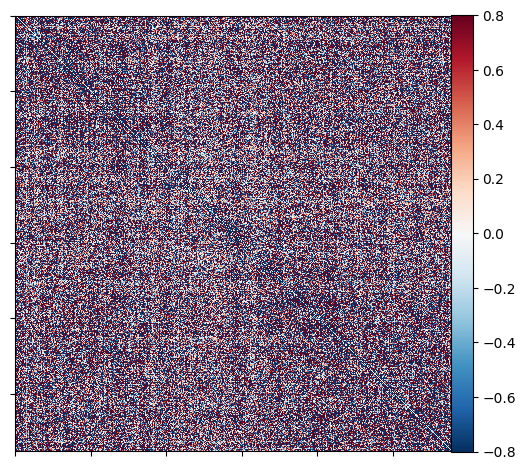

In [8]:
correlation_measure = ConnectivityMeasure(kind='precision')
correlation_matrix = correlation_measure.fit_transform([masks[subject_id]])[0]

fig = plt.figure()

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, colorbar=True,
                     vmax=0.8,
                     vmin=-0.8,
                     figure = fig)
plotting.show()


fig.savefig(os.path.join(explanatory_fMRI_dir, 'precision.png'))

### Partial Correlation 

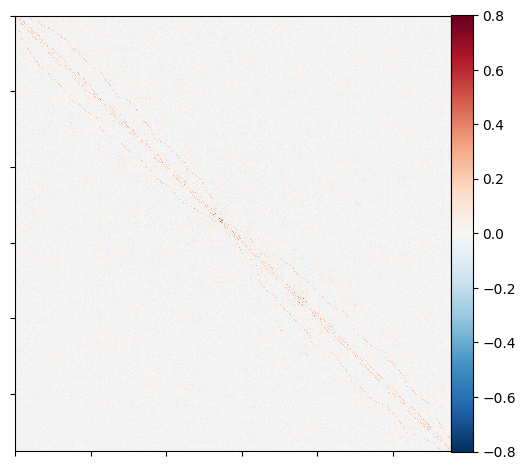

In [9]:
correlation_measure = ConnectivityMeasure(kind='partial correlation')
correlation_matrix = correlation_measure.fit_transform([masks[subject_id]])[0]
fig = plt.figure()

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, colorbar=True,
                     vmax=0.8, vmin=-0.8,figure = fig)
plotting.show()
fig.savefig(os.path.join(explanatory_fMRI_dir, 'partial_correlation.png'))

## Similarity Analysis

### Cosine 

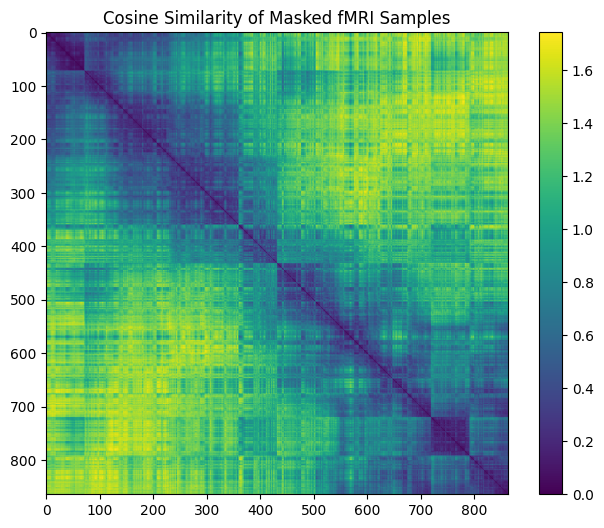

In [11]:
fig = plt.figure(figsize=(8,6))
plt.imshow(cdist(masks[subject_id], masks[subject_id], metric='cosine'))
plt.colorbar()
plt.title('Cosine Similarity of Masked fMRI Samples')
plt.show()
fig.savefig(os.path.join(explanatory_fMRI_dir, 'cosine.png'))

###  Minkowski

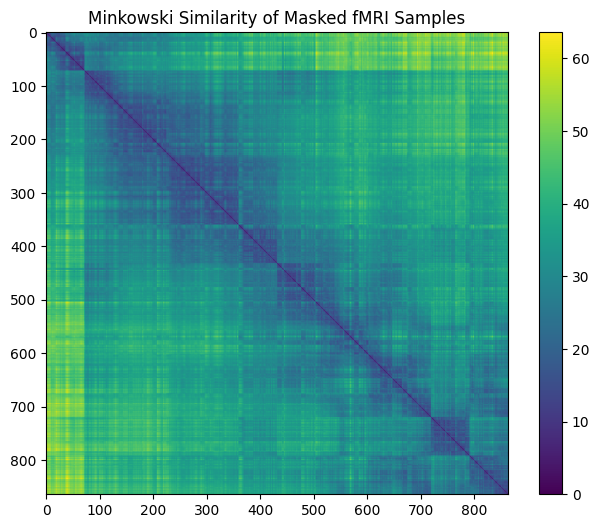

In [12]:
fig = plt.figure(figsize=(8,6))
plt.imshow(cdist(masks[subject_id], masks[subject_id], metric='minkowski'))
plt.colorbar()
plt.title('Minkowski Similarity of Masked fMRI Samples')
plt.show()
fig.savefig(os.path.join(explanatory_fMRI_dir, 'minkowski.png'))

### Euclidean

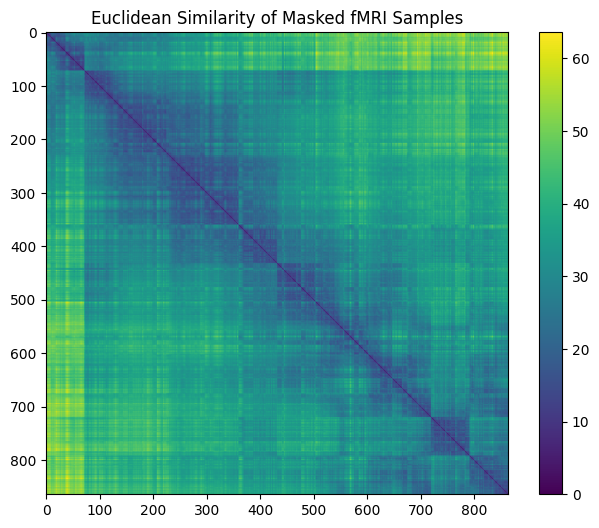

In [13]:
fig = plt.figure(figsize=(8,6))
plt.imshow(cdist(masks[subject_id], masks[subject_id]))
plt.colorbar()
plt.title('Euclidean Similarity of Masked fMRI Samples')
plt.show()
fig.savefig(os.path.join(explanatory_fMRI_dir, 'euclidean.png'))

<tr>
    <td><img src="images/result_fc.png"></td>
</tr>

* Temporal functional connectivity provides **informative** for different stimuli
* However, directly is still **high-dimensional and redundant**, which limits the performance
* **Dimension reduction methods** (to extract low-rank and implicit temporal pattern) and extensive **Manifold Learning methods** are required for better decoding performance